In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,roc_curve
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.over_sampling import SMOTE
! pip install shap
import shap
from tqdm import tqdm

# 1. 数据预处理与探索性分析

## 1.1 数据加载与基本信息

In [129]:
df = pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119795 entries, 0 to 119794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      119795 non-null  object 
 1   BMI               119795 non-null  float64
 2   Smoking           119795 non-null  object 
 3   AlcoholDrinking   119795 non-null  object 
 4   Stroke            119795 non-null  object 
 5   PhysicalHealth    119795 non-null  float64
 6   MentalHealth      119795 non-null  float64
 7   DiffWalking       119795 non-null  object 
 8   Sex               119795 non-null  object 
 9   AgeCategory       119795 non-null  object 
 10  Race              119795 non-null  object 
 11  Diabetic          119795 non-null  object 
 12  PhysicalActivity  119795 non-null  object 
 13  GenHealth         119795 non-null  object 
 14  SleepTime         119795 non-null  float64
 15  Asthma            119795 non-null  object 
 16  KidneyDisease     11

In [131]:
df.head(10)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,21.24,No,No,No,0.0,1.0,No,Male,25-29,Hispanic,No,Yes,Very good,8.0,No,No,No
1,No,31.32,No,No,No,0.0,2.0,No,Male,50-54,American Indian/Alaskan Native,No,No,Fair,6.0,No,No,No
2,No,36.59,Yes,No,No,0.0,0.0,No,Male,18-24,American Indian/Alaskan Native,No,Yes,Good,10.0,No,No,No
3,No,27.20,No,No,No,3.0,10.0,No,Male,55-59,White,No,Yes,Good,6.0,No,No,No
4,No,34.46,No,No,Yes,30.0,0.0,Yes,Female,70-74,White,Yes,Yes,Poor,9.0,No,No,Yes
5,No,29.05,No,No,No,0.0,0.0,No,Male,80 or older,White,No,No,Excellent,8.0,No,No,No
6,No,22.60,Yes,No,No,0.0,0.0,No,Male,35-39,American Indian/Alaskan Native,No,Yes,Good,7.0,No,No,No
7,No,25.69,Yes,No,No,0.0,0.0,No,Female,70-74,White,No,Yes,Very good,9.0,No,No,No
8,No,32.28,Yes,No,No,0.0,0.0,Yes,Male,70-74,Hispanic,Yes,Yes,Fair,8.0,No,No,No
9,No,27.88,Yes,No,No,30.0,29.0,Yes,Male,45-49,Hispanic,No,Yes,Good,6.0,Yes,No,No


In [133]:
# 定量数据描述分析
df.describe()

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,119795.000000,119795.000000,119795.000000,119795.000000
mean,28.393629,3.442164,3.951200,7.074811
std,6.369269,8.032375,8.046172,1.431280
min,12.020000,0.000000,0.000000,1.000000
25%,24.090000,0.000000,0.000000,6.000000
50%,27.370000,0.000000,0.000000,7.000000
75%,31.530000,2.000000,3.000000,8.000000
max,94.660000,30.000000,30.000000,24.000000


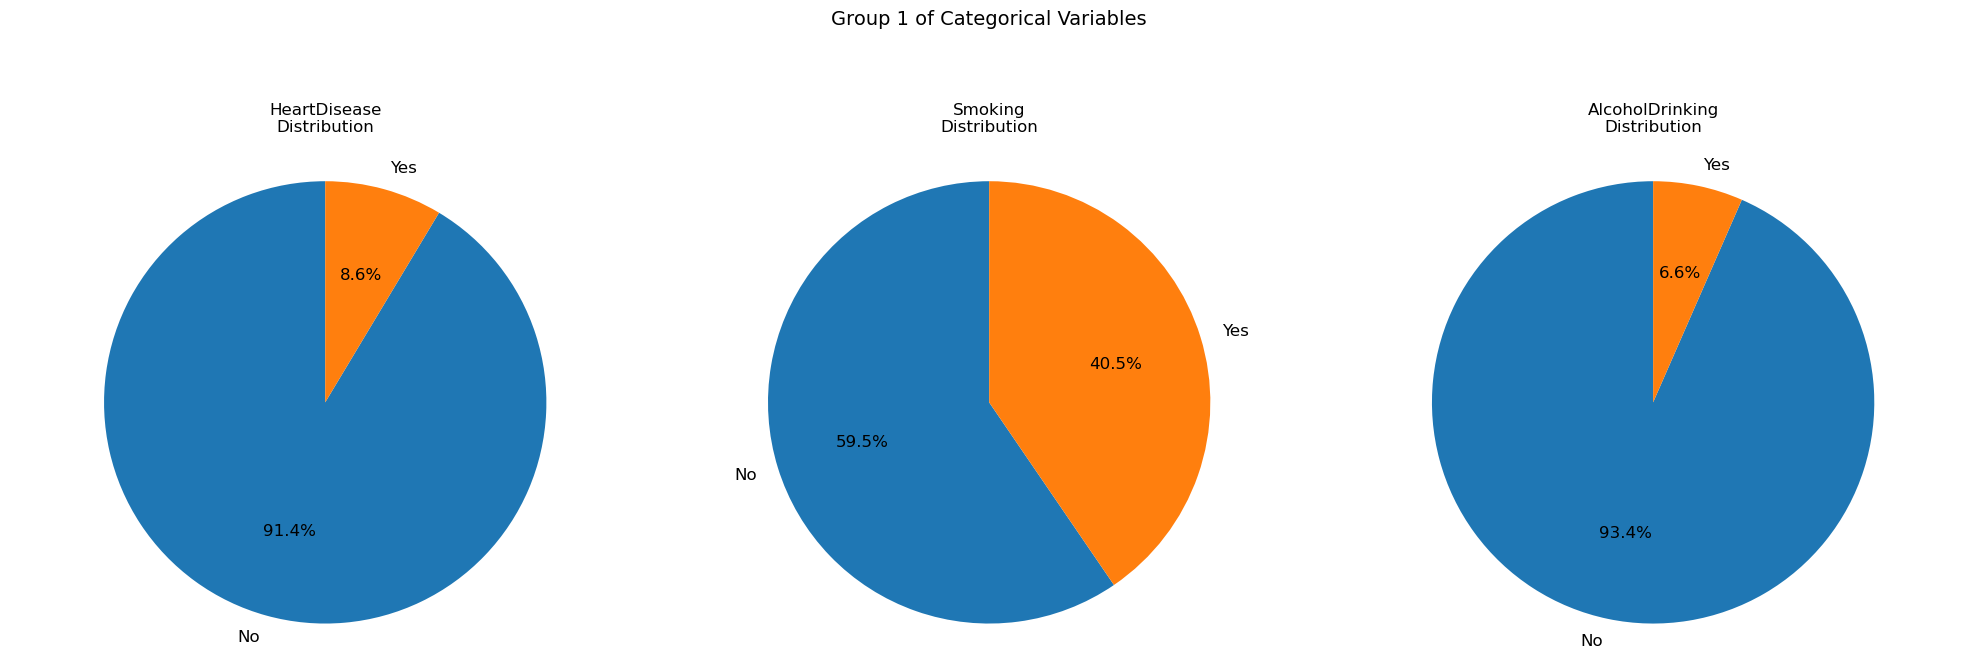

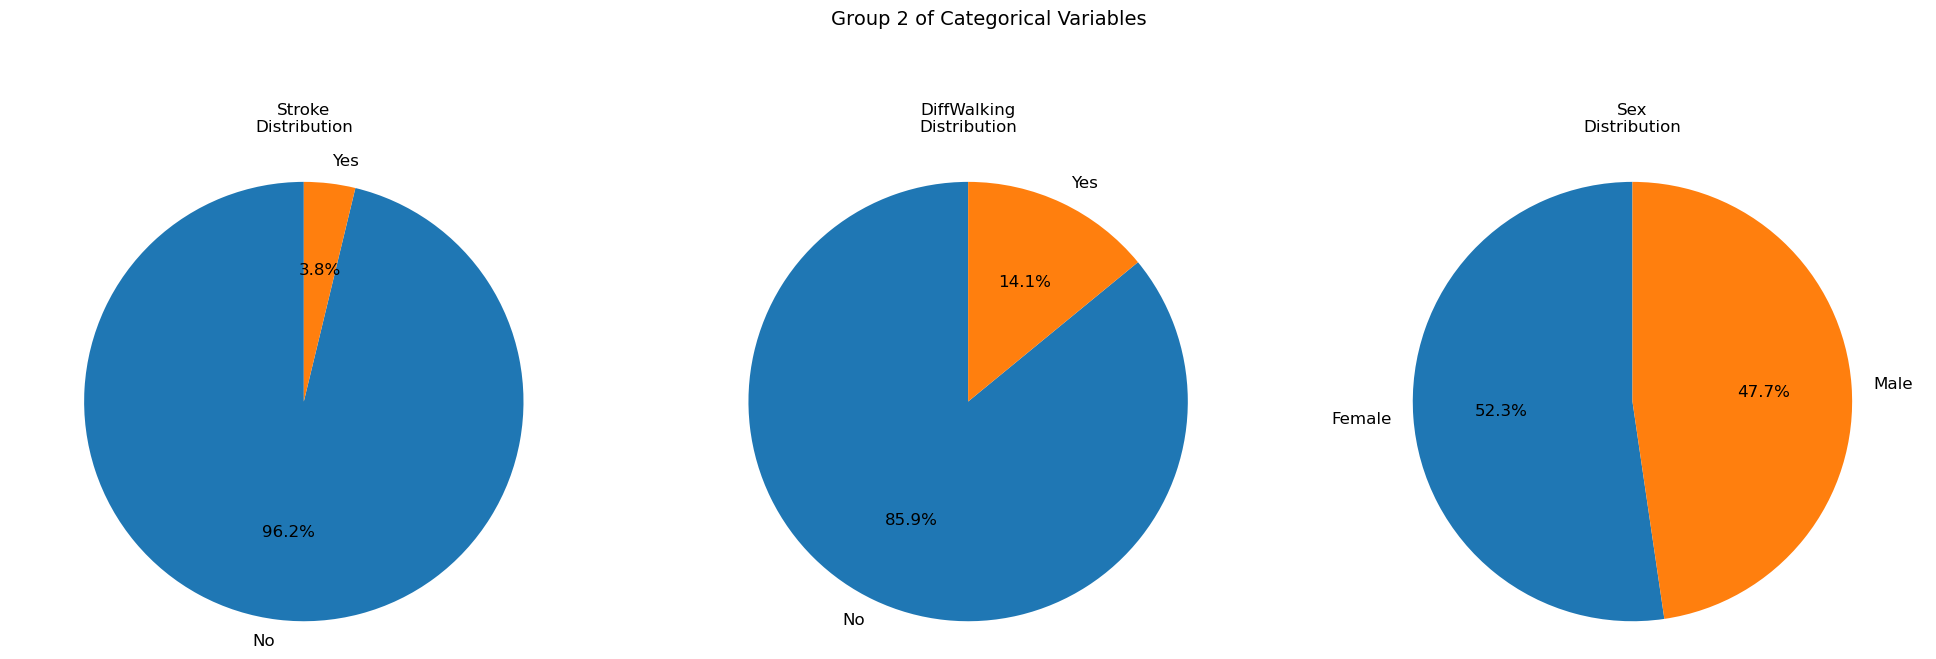

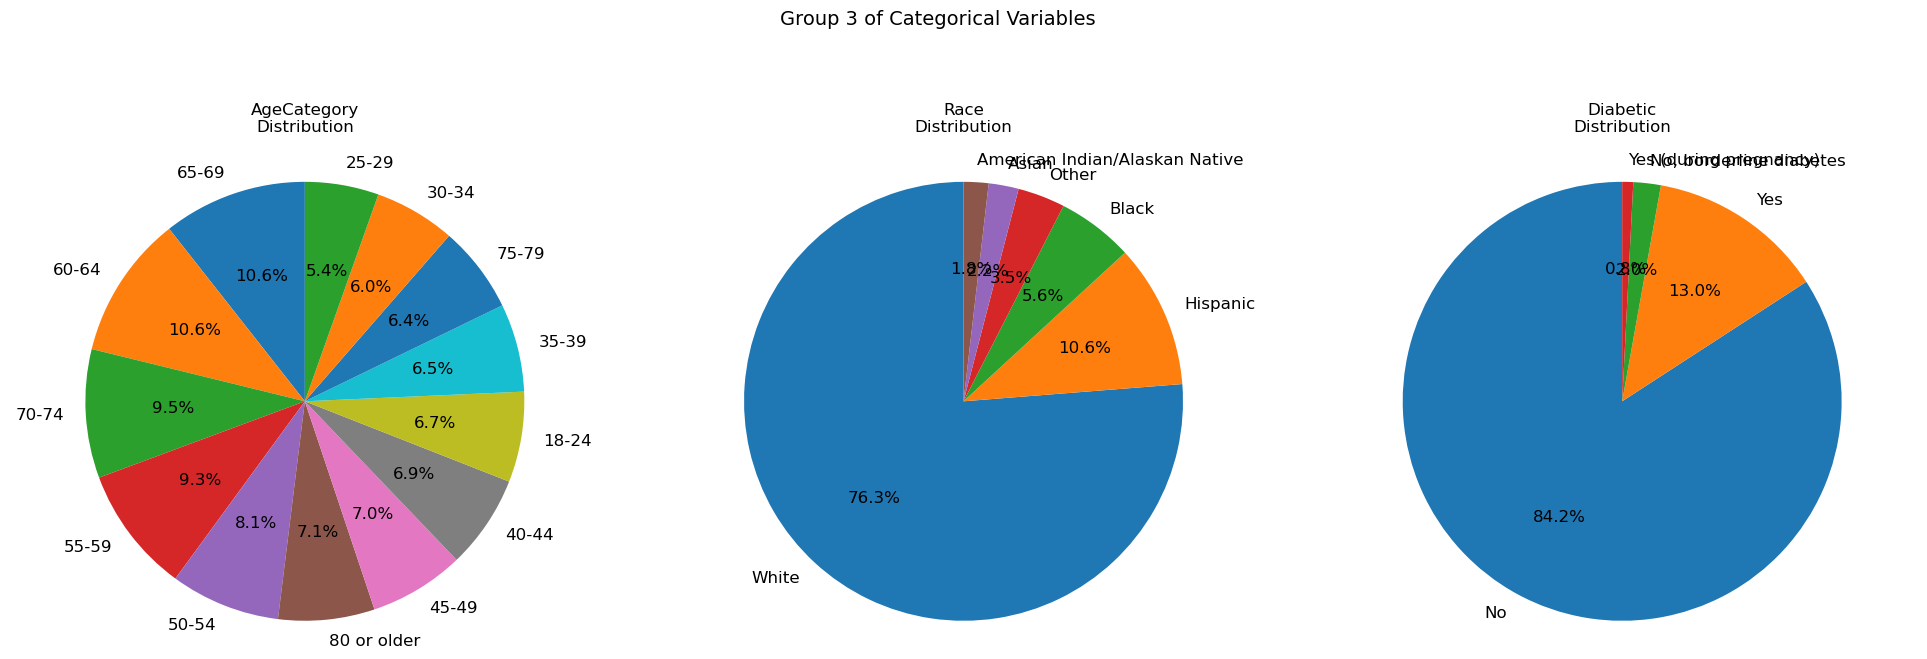

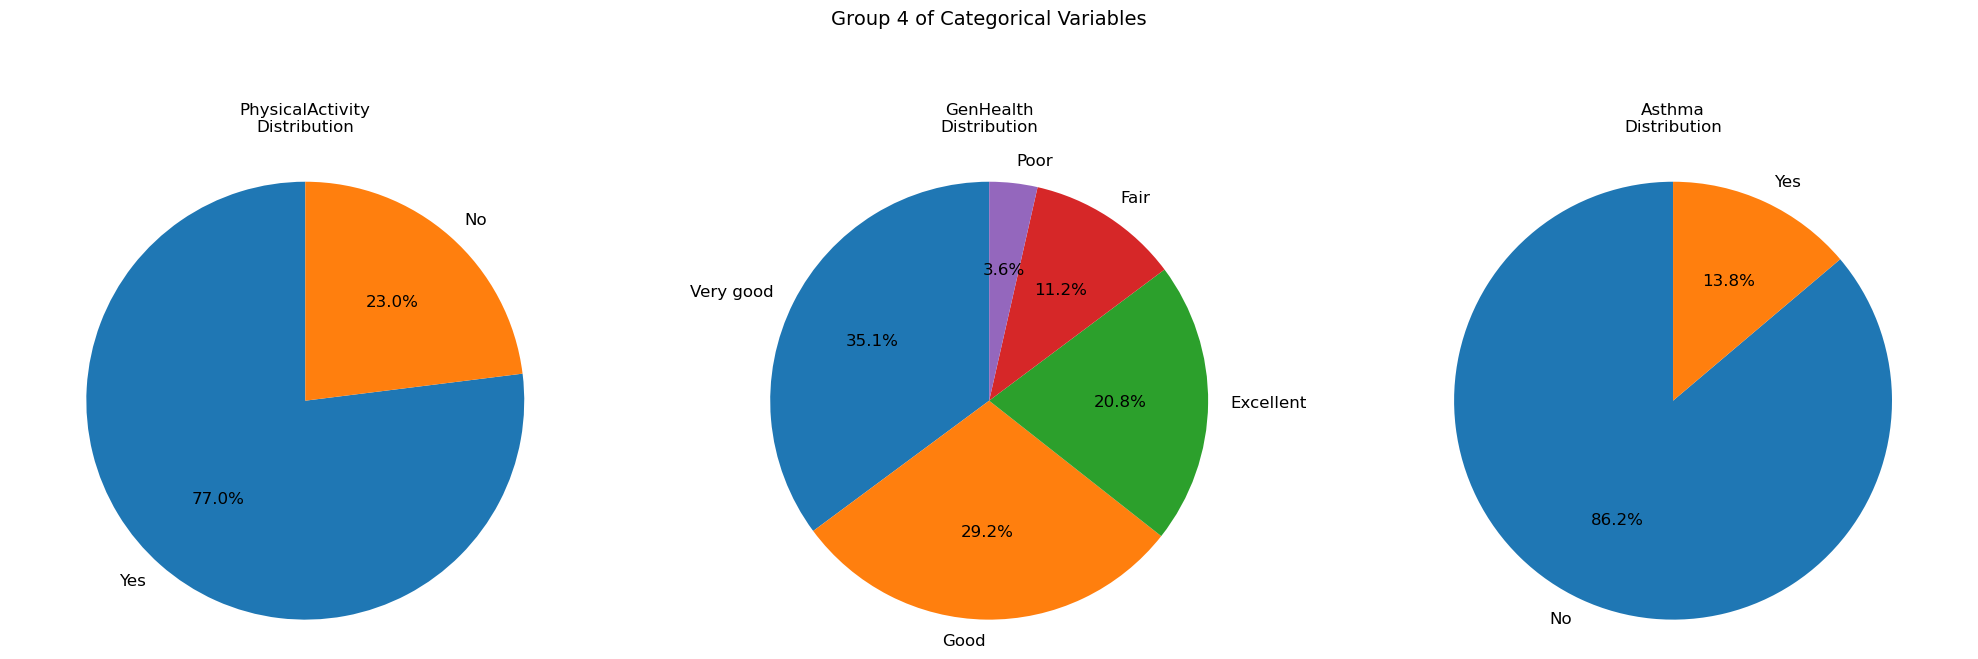

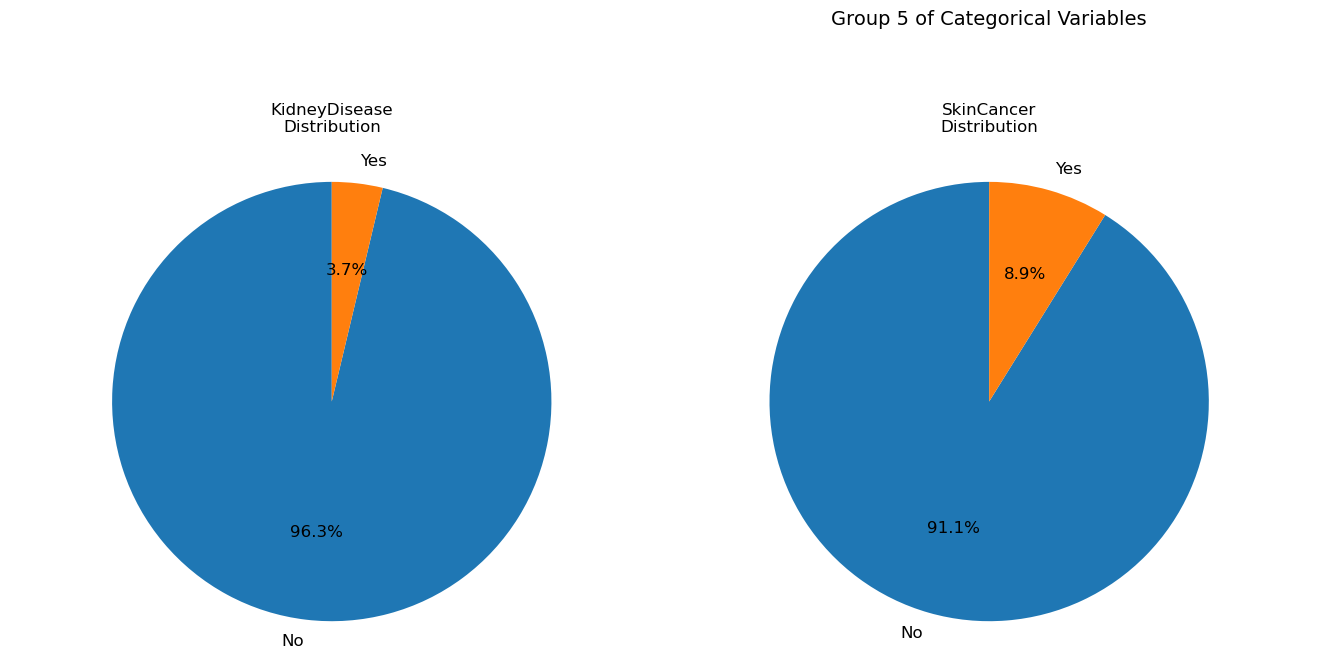

In [135]:
# 定量数据描述分析
def plot_categorical_pie(df, qualitative_vars, rows=1, cols=3, figsize=(20, 6)):
    """
    优化版：缩小间距，增大标签字体
    """
    groups = [qualitative_vars[i:i+3] for i in range(0, len(qualitative_vars), 3)]
    
    for i, group in enumerate(groups, 1):
        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        fig.suptitle(f'Group {i} of Categorical Variables', fontsize=14, y=1.1)
        
        for j, var in enumerate(group):
            ax = axes[j] if rows == 1 else axes[j//cols, j%cols]
            
            counts = df[var].value_counts()
            labels = counts.index
            sizes = counts.values
            
            ax.pie(sizes, 
                   labels=labels, 
                   autopct='%1.1f%%',
                   startangle=90,
                   textprops={'fontsize': 12})  # 调整标签字体大小
            ax.set_title(f'{var}\nDistribution', fontsize=12, pad=20)  # 标题调整
            ax.axis('equal')
            
        # 隐藏多余子图并调整布局
        for k in range(len(group), rows*cols):
            axes.flatten()[k].set_visible(False)
            
        plt.tight_layout(pad=1.5, h_pad=1.0, w_pad=1.0)  # 调整子图间距
        plt.subplots_adjust(top=0.85)  # 减少标题与子图的间距
        plt.show()

qualitative_vars = list(df.select_dtypes(include=['object']).columns)

plot_categorical_pie(df, qualitative_vars)

## 1.2 数据清洗

In [17]:
# 处理二分类变量
binary_cols = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Diabetic', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# 处理目标变量
df['HeartDisease'] = df['HeartDisease'].map({'Yes': 1, 'No': 0})

# 处理有序类别AgeCategory
def age_to_num(age_str):
    if 'or older' in age_str:
        return 85
    start, end = map(int, age_str.split('-'))
    return (start + end) / 2

df['AgeCategory'] = df['AgeCategory'].apply(age_to_num)

# 处理GenHealth
gen_health_order = {'Poor':1, 'Fair':2, 'Good':3, 'Very good':4, 'Excellent':5}
df['GenHealth'] = df['GenHealth'].map(gen_health_order)

# 独热编码Race
df = pd.get_dummies(df, columns=['Race'], drop_first=True)

# 处理Sex
df['Sex'] = df['Sex'].map({'Male': 0, 'Female': 1})


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119795 entries, 0 to 119794
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      119795 non-null  int64  
 1   BMI               119795 non-null  float64
 2   Smoking           119795 non-null  int64  
 3   AlcoholDrinking   119795 non-null  int64  
 4   Stroke            119795 non-null  int64  
 5   PhysicalHealth    119795 non-null  float64
 6   MentalHealth      119795 non-null  float64
 7   DiffWalking       119795 non-null  int64  
 8   Sex               119795 non-null  int64  
 9   AgeCategory       119795 non-null  float64
 10  Diabetic          116408 non-null  float64
 11  PhysicalActivity  119795 non-null  int64  
 12  GenHealth         119795 non-null  int64  
 13  SleepTime         119795 non-null  float64
 14  Asthma            119795 non-null  int64  
 15  KidneyDisease     119795 non-null  int64  
 16  SkinCancer        11

In [21]:
df.head(5)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,...,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White
0,0,21.24,0,0,0,0.0,1.0,0,0,27.0,...,4,8.0,0,0,0,False,False,True,False,False
1,0,31.32,0,0,0,0.0,2.0,0,0,52.0,...,2,6.0,0,0,0,False,False,False,False,False
2,0,36.59,1,0,0,0.0,0.0,0,0,21.0,...,3,10.0,0,0,0,False,False,False,False,False
3,0,27.20,0,0,0,3.0,10.0,0,0,57.0,...,3,6.0,0,0,0,False,False,False,False,True
4,0,34.46,0,0,1,30.0,0.0,1,1,72.0,...,1,9.0,0,0,1,False,False,False,False,True


## 1.3 EDA

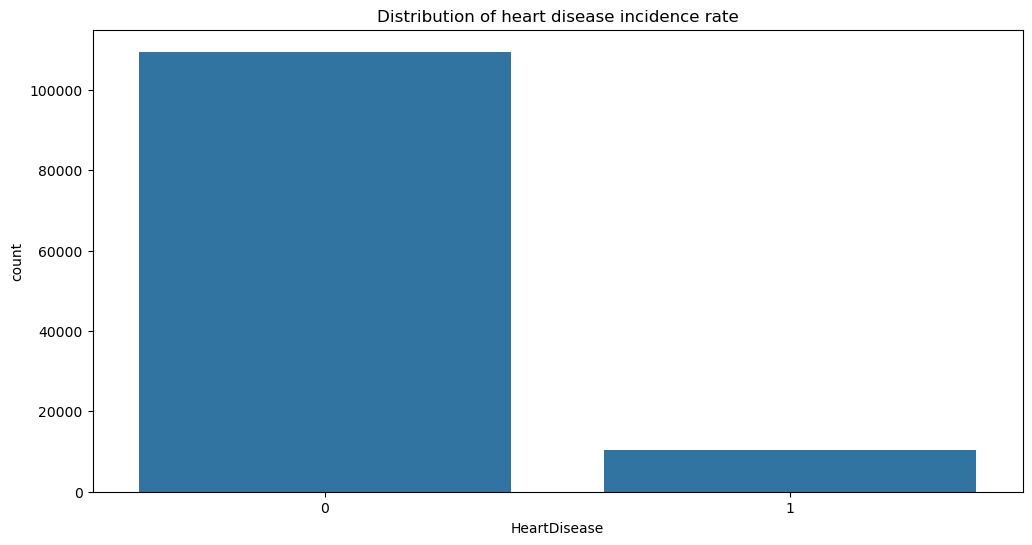

In [24]:
# 可视化
plt.figure(figsize=(12, 6))
sns.countplot(x='HeartDisease', data=df)
plt.title('Distribution of heart disease incidence rate') #心脏病患病率分布
plt.show()

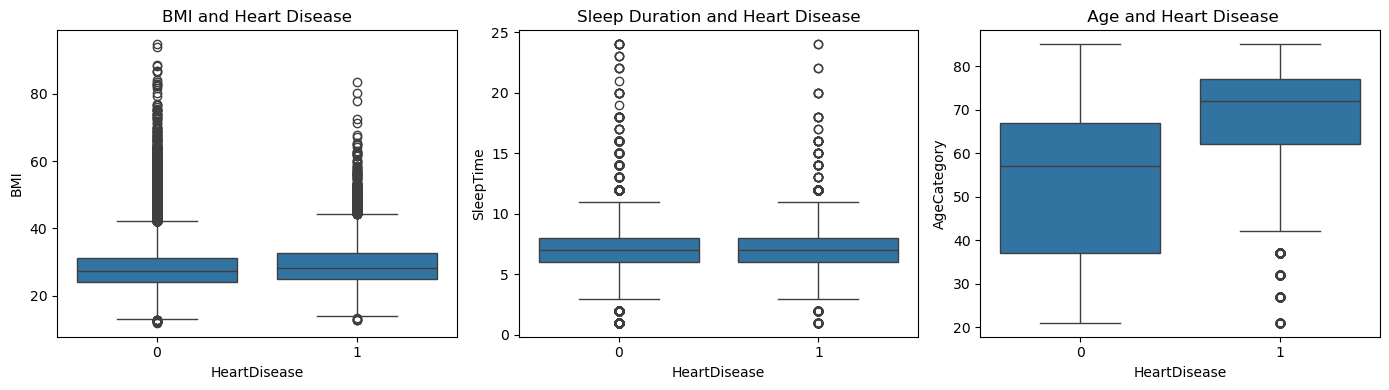

In [26]:
# 连续变量与心脏病关系
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
sns.boxplot(x='HeartDisease', y='BMI', data=df)
plt.title('BMI and Heart Disease') # BMI与心脏病关系

plt.subplot(1, 3, 2)
sns.boxplot(x='HeartDisease', y='SleepTime', data=df)
plt.title('Sleep Duration and Heart Disease') # SleepTime与心脏病关系

plt.subplot(1, 3, 3)
sns.boxplot(x='HeartDisease', y='AgeCategory', data=df)
plt.title(' Age and Heart Disease') #  年龄与心脏病关系
plt.tight_layout()
plt.show()

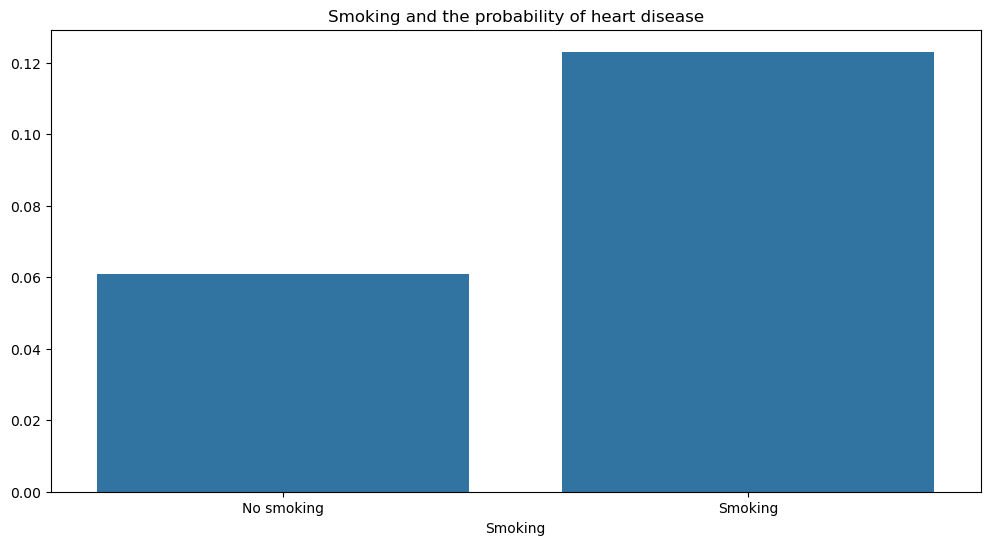

In [28]:
# 分类变量柱状图
plt.figure(figsize=(12, 6))
sns.barplot(x=df.groupby('Smoking')['HeartDisease'].mean().index,
            y=df.groupby('Smoking')['HeartDisease'].mean().values)
plt.title('Smoking and the probability of heart disease')
plt.xticks([0, 1], ['No smoking', 'Smoking'])
plt.show()

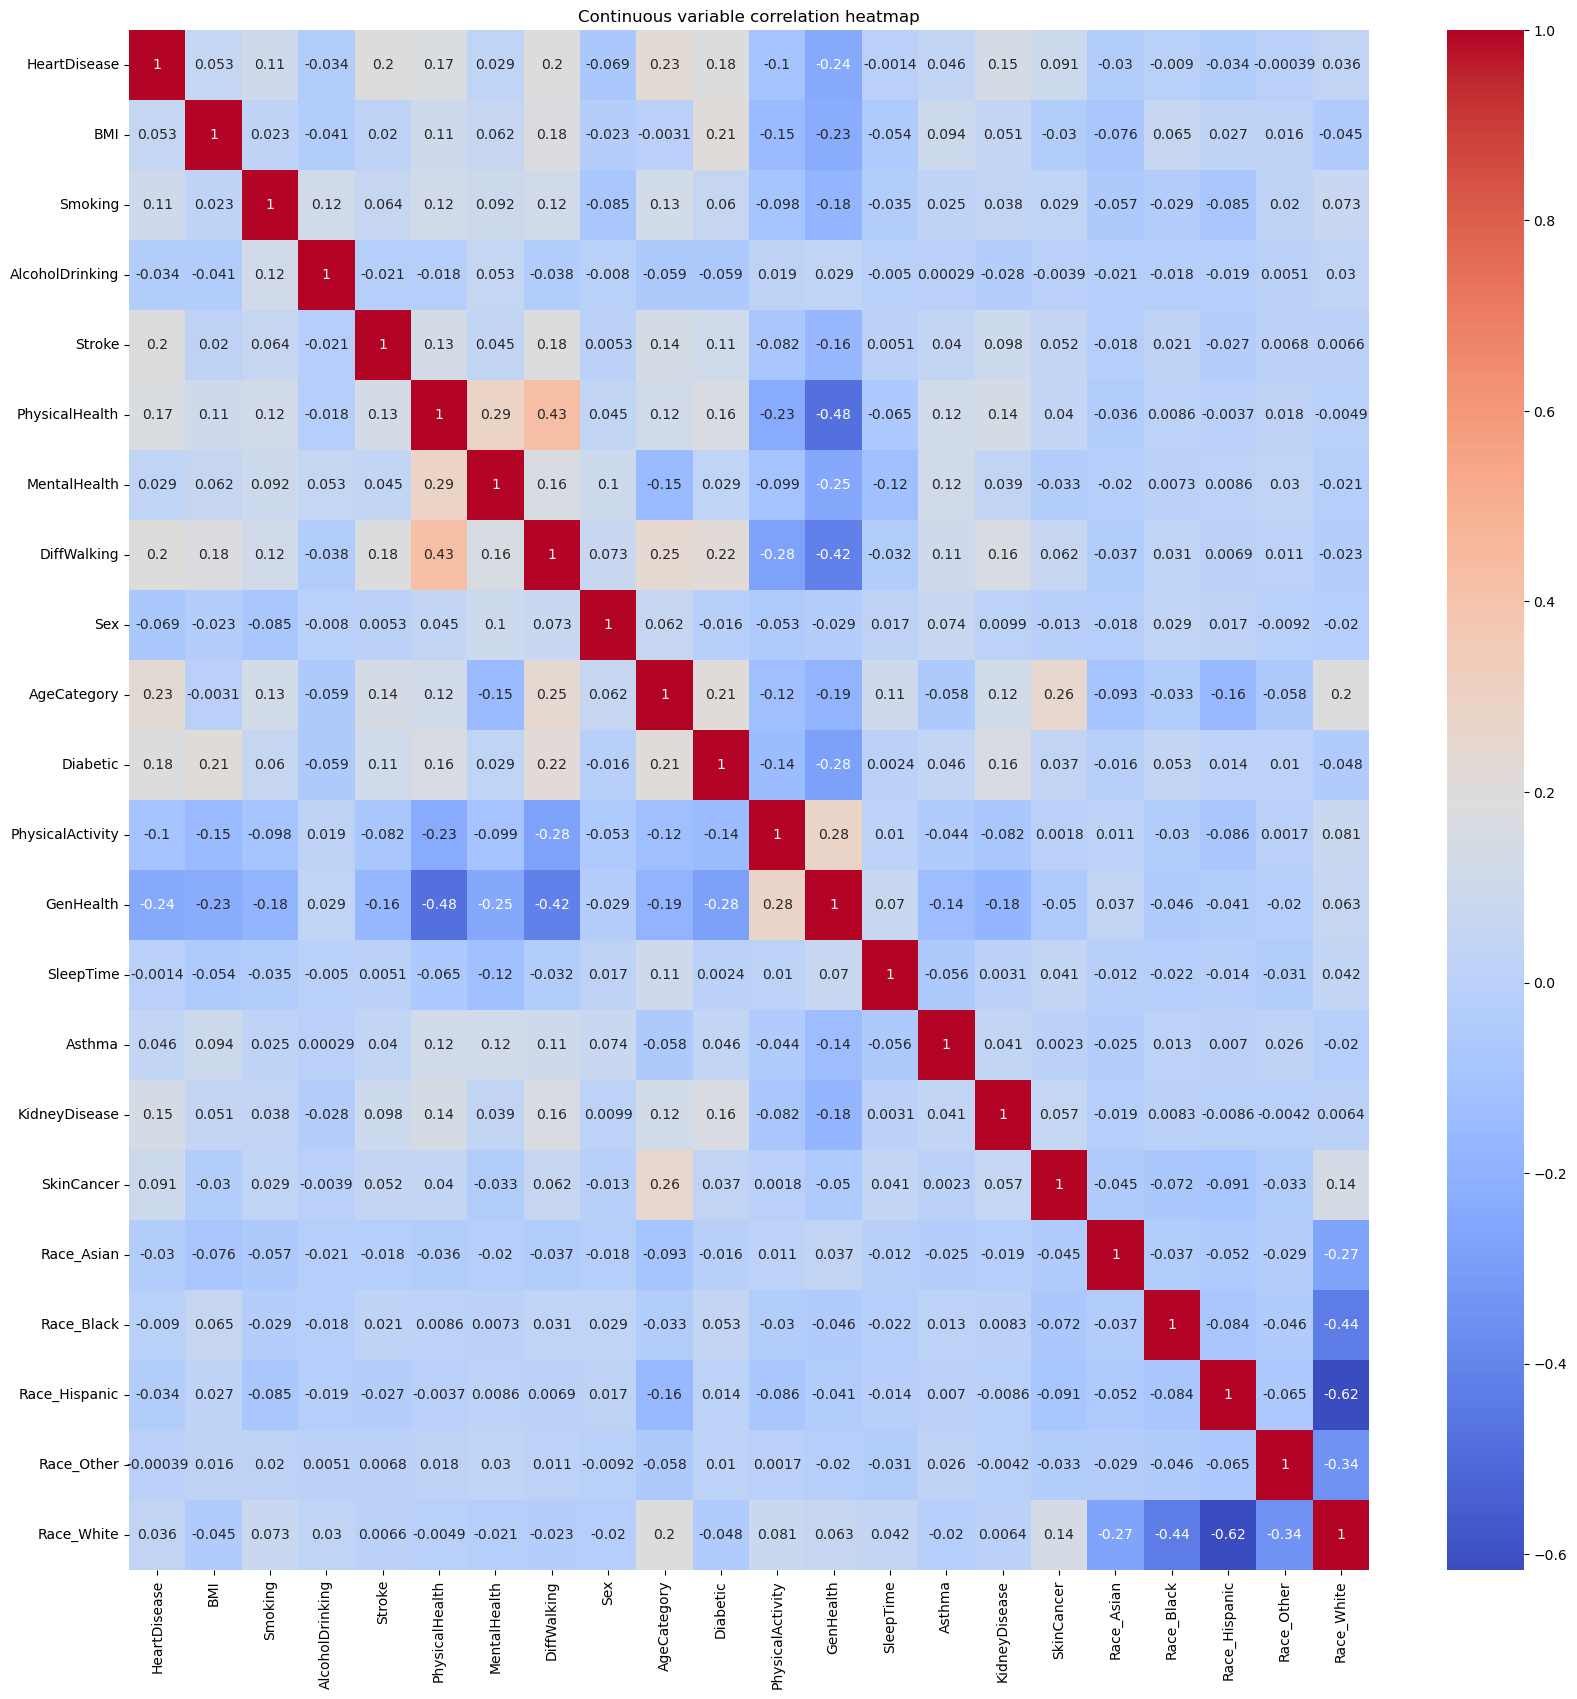

In [30]:
# 相关性热力图
corr_matrix = df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Continuous variable correlation heatmap')
plt.show()

# 2. 特征工程

In [87]:
df = pd.read_csv('data.csv')

# 1. 风险因素计数（Risk Factor Count）
risk_factors = ['Smoking', 'AlcoholDrinking', 'Stroke', 'Diabetic', 'Asthma', 'KidneyDisease', 'SkinCancer']
df['RiskCount'] = df[risk_factors].map(lambda x: 1 if x == 'Yes' else 0).sum(axis=1)

# 2. 年龄中位数转换（Age as Continuous）
age_mapping = {
    '18-24': 21, '25-29': 27, '30-34': 32, '35-39': 37,
    '40-44': 42, '45-49': 47, '50-54': 52, '55-59': 57,
    '60-64': 62, '65-69': 67, '70-74': 72, '75-79': 77,
    '80 or older': 85
}
df['Age'] = df['AgeCategory'].map(age_mapping)

# 3. BMI分类（BMI Category）
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 0    #underweight
    elif 18.5 <= bmi < 25:
        return 1    #Normal
    elif 25 <= bmi < 30:
        return 2    #Overweight
    else:
        return 3    #Obese

df['BMICategory'] = df['BMI'].apply(categorize_bmi)

# 4. 总健康问题天数（Total Health Issues）
df['TotalHealthIssues'] = df['PhysicalHealth'] + df['MentalHealth']

# 5. 睡眠与健康状态的交互（Sleep & Health Interaction）
df['SleepHealthRisk'] = 0
df.loc[(df['SleepTime'] < 7) & (df['GenHealth'].isin(['Poor', 'Fair'])), 'SleepHealthRisk'] = 1

# 6. 是否有多个慢性病（Chronic Disease Comorbidity）
chronic_diseases = ['Diabetic', 'Stroke', 'KidneyDisease', 'SkinCancer']
df['Comorbidity'] = df[chronic_diseases].map(lambda x: 1 if x == 'Yes' else 0).sum(axis=1)
df['Comorbidity'] = df['Comorbidity'].apply(lambda x: 1 if x >= 2 else 0)

# 7. 性别与年龄的交互（Gender-Age Interaction）
df['Male_Age'] = df.apply(lambda row: row['Age'] if row['Sex'] == 'Male' else 0, axis=1)

# 8. 健康行为与健康状态的组合（Lifestyle & Health）
df['HealthyLifestyle'] = 0
df.loc[(df['PhysicalActivity'] == 'Yes') & 
       (df['GenHealth'].isin(['Good', 'Very good', 'Excellent'])) & 
       (df['SleepTime'] >= 7), 'HealthyLifestyle'] = 1

# 9. BMI与年龄的交互（BMI-Age Interaction）
df['BMI_Age'] = df['BMI'] * df['Age']

# 10. 走行困难与年龄（DiffWalking & Age）
df['MobilityRisk'] = 0
df.loc[(df['DiffWalking'] == 'Yes') & (df['Age'] >= 60), 'MobilityRisk'] = 1

In [88]:
# 处理二分类变量
binary_cols = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Diabetic', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# 处理目标变量
df['HeartDisease'] = df['HeartDisease'].map({'Yes': 1, 'No': 0})

# 处理有序类别AgeCategory
def age_to_num(age_str):
    if 'or older' in age_str:
        return 85
    start, end = map(int, age_str.split('-'))
    return (start + end) / 2

df['AgeCategory'] = df['AgeCategory'].apply(age_to_num)

# 处理GenHealth
gen_health_order = {'Poor':1, 'Fair':2, 'Good':3, 'Very good':4, 'Excellent':5}
df['GenHealth'] = df['GenHealth'].map(gen_health_order)

# 独热编码Race
df = pd.get_dummies(df, columns=['Race'], drop_first=True)

# 处理Sex
df['Sex'] = df['Sex'].map({'Male': 0, 'Female': 1})

In [91]:
# 删除缺失值
df.dropna(inplace=True)

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116408 entries, 0 to 119794
Data columns (total 32 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   HeartDisease       116408 non-null  int64  
 1   BMI                116408 non-null  float64
 2   Smoking            116408 non-null  int64  
 3   AlcoholDrinking    116408 non-null  int64  
 4   Stroke             116408 non-null  int64  
 5   PhysicalHealth     116408 non-null  float64
 6   MentalHealth       116408 non-null  float64
 7   DiffWalking        116408 non-null  int64  
 8   Sex                116408 non-null  int64  
 9   AgeCategory        116408 non-null  float64
 10  Diabetic           116408 non-null  float64
 11  PhysicalActivity   116408 non-null  int64  
 12  GenHealth          116408 non-null  int64  
 13  SleepTime          116408 non-null  float64
 14  Asthma             116408 non-null  int64  
 15  KidneyDisease      116408 non-null  int64  
 16  SkinCan

In [99]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']
# 标准化连续变量
continuous_vars = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime', 'AgeCategory']
scaler = StandardScaler()
X[continuous_vars] = scaler.fit_transform(X[continuous_vars])

# 处理类别不平衡
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [101]:
X_resampled.shape, y_resampled.shape

((212856, 31), (212856,))

# 3. 统计建模与分析

## 3.1 仅使用原始特征

In [105]:
# 新建特征列表
new_features_base = [
    'RiskCount',          # 风险因素计数
    'Age',                # 年龄中位数转换
    'BMICategory',        # BMI分类
    'TotalHealthIssues',  # 总健康问题天数
    'SleepHealthRisk',    # 睡眠与健康状态交互
    'Comorbidity',        # 是否有多个慢性病
    'Male_Age',           # 性别与年龄交互
    'HealthyLifestyle',   # 健康行为与健康状态组合
    'BMI_Age',            # BMI与年龄交互
    'MobilityRisk'        # 走行困难与年龄
]
# 提取原始特征列
original_features = [col for col in X_resampled.columns if col not in new_features_base]


# 创建只包含原始特征的新DataFrame
X_original_features = X_resampled[original_features]

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X_original_features, y_resampled, test_size=0.3, random_state=42)

# 模型训练
models = {
    'LR': LogisticRegression(max_iter=2000),
    'RF': RandomForestClassifier(n_estimators=100, random_state=42),
    'LASSO': LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
}

original_features_results = {}
for name, model in tqdm(models.items(), desc="模型训练进度"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # 评估指标
    metrics = {
        'F1': f1_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba)
    }
    original_features_results[name] = metrics

# 4. 结果输出与可视化
# 模型性能表
print("\n原始特征,模型性能对比：")
pd.DataFrame(original_features_results).T

模型训练进度: 100%|█████████████████████████████████| 3/3 [00:12<00:00,  4.15s/it]


原始特征,模型性能对比：


,F1,Precision,Recall,AUC
LR,0.847877,0.842588,0.853234,0.923289
RF,0.936302,0.949195,0.923755,0.981338
LASSO,0.847886,0.842635,0.853202,0.923309


## 3.2 加入新建的特征

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 模型训练
models = {
    'LR': LogisticRegression(max_iter=2000),
    'RF': RandomForestClassifier(n_estimators=100, random_state=42),
    'LASSO': LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
}

features_results = {}
for name, model in tqdm(models.items(), desc="模型训练进度"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # 评估指标
    metrics = {
        'F1': f1_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba)
    }
    features_results[name] = metrics

# 4. 结果输出与可视化
# 模型性能表
print("\n加入新建特征,模型性能对比：")
pd.DataFrame(features_results).T

模型训练进度:   0%|                                         | 0/3 [00:00<?, ?it/s]/Applications/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
模型训练进度: 100%|████████████████████████████████| 3/3 [05:32<00:00, 110.67s/it]


加入新建特征,模型性能对比：


,F1,Precision,Recall,AUC
LR,0.858162,0.870404,0.846260,0.937729
RF,0.942423,0.955074,0.930104,0.984393
LASSO,0.869148,0.879814,0.858738,0.944761


# 4. 结果输出与可视化

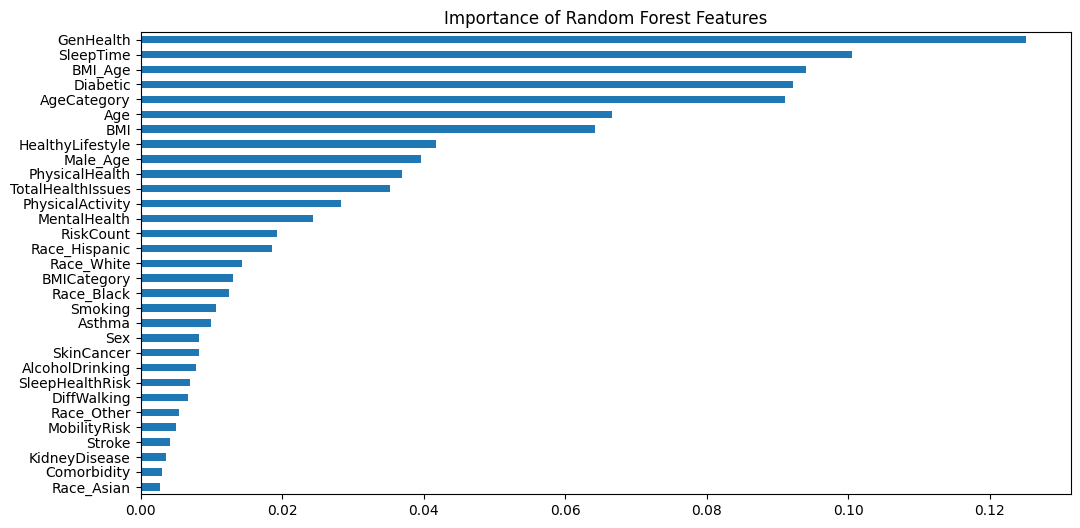

In [44]:
# 特征重要性
plt.figure(figsize=(12, 6))
rf = models['RF']
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values().plot.barh()
plt.title('Importance of Random Forest Features')
plt.show()


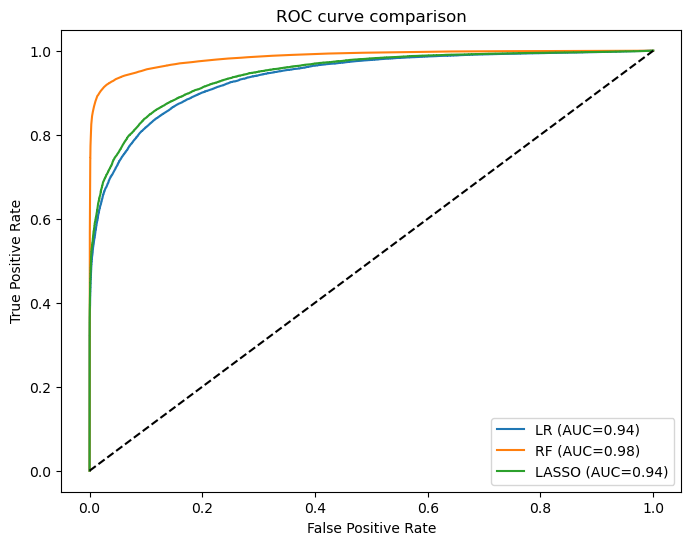

In [113]:
# ROC曲线
plt.figure(figsize=(8,6))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc_score(y_test, y_proba):.2f})')

plt.plot([0,1],[0,1], 'k--')
plt.title('ROC curve comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


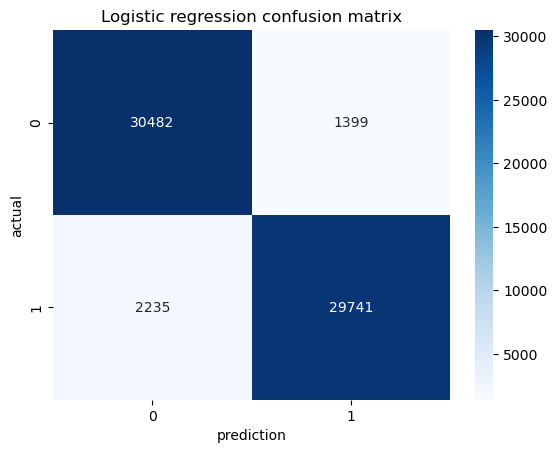

In [115]:

# 混淆矩阵
cm = confusion_matrix(y_test, models['RF'].predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic regression confusion matrix')
plt.xlabel('prediction')
plt.ylabel('actual')
plt.show()



# 5. 模型检查